### Q3(3) Semi-Supervised Learning

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [20]:
# finding normalization params for gray scale SVHN dataset : since model will be trained/tested on it
x=np.load('SVHN/train_x.npy').sum(axis=1)/(3.*255.)
mean=x.mean(axis=0).mean()
std=x.std(axis=0).mean()
print('mean and stddev of svhn data set (after making it GrayScale)')
print(mean, std)

mean and stddev of svhn data set (after making it GrayScale)
0.45141874380091884 0.19392833492380085


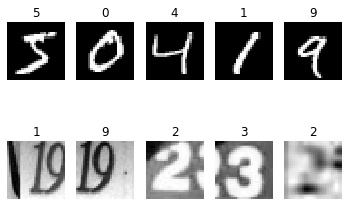

In [25]:
# plt.figure(figsize=(8.,6.))
x1=np.load('MNIST/train_x.npy')
y1=np.load('MNIST/train_y.npy')
x2=np.load('SVHN/train_x.npy')
y2=np.load('SVHN/train_y.npy')
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.title(y1[i])
    plt.imshow(x1[i]/255.,cmap='gray')
    plt.subplot(2,5,i+6)
    plt.axis('off')
    plt.title(y2[i])
    plt.imshow(x2[i].sum(axis=0)/(3*255.),cmap='gray')
plt.savefig('q3_part3_bothDS.png')
plt.show()

In [40]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.fc1   = nn.Linear(16*7*7, 120)
        self.fc2   = nn.Linear(120, 10)
    def forward(self, x):
        out = F.relu(self.conv1(x)) #6,28,28
        out = F.max_pool2d(out, 2) #6,14,14
        out = F.relu(self.conv2(out)) #16,14,14
        out = F.max_pool2d(out, 2) #16,7,7
        out = out.view(out.size(0), -1) 
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

class Mnist_SVHN(Dataset):
    def __init__(self,train,data_set):
        self.train = train
        type_ = 'train' if train else 'test'
        Images_path='drive/My Drive/q3/'+data_set+'/'+type_+'_x.npy'
        Labels_path='drive/My Drive/q3/'+data_set+'/'+type_+'_y.npy'
        self.imgs=np.load(Images_path)
        self.lbls=np.load(Labels_path)
        if data_set=='SVHN':
          self.imgs=self.imgs.transpose((0,2,3,1))
    def __getitem__(self, index):
        img, target = self.imgs[index], self.lbls[index]
        shape = img.shape
        img = Image.fromarray(img.astype(np.uint8))
        if self.train == True: # Apply train transform
            t1 = transforms.Compose(
                    [transforms.RandomCrop(shape[0], padding=4), 
                    transforms.RandomHorizontalFlip()]) 
            img = t1(img)
        if len(shape)==3:
            t = transforms.Compose(
                    [transforms.Grayscale(), 
                    transforms.Resize((28,28)),
                    transforms.ToTensor(),
                    transforms.Normalize(0.45141874380091884, 0.19392833492380085)]) 
            img = t(img)
        else:
            t2 = transforms.Compose(
                [transforms.ToTensor()])
            img = t2(img)        
        return img, target
    def __len__(self):
        return self.imgs.shape[0]

#### train the model on MNIST and test it on SVHN

In [41]:
def main():
    exp_name='q3_part3_mnist'
    torch.manual_seed(1)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(torch.cuda.get_device_properties(0))
    # Data
    print('==> Preparing data..')
    trainset = Mnist_SVHN(train=True,data_set='MNIST')
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = Mnist_SVHN(train=False,data_set='SVHN')
    testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
    print('==> Building model..')
    net = LeNet()
    net = net.to(device)
    if device == 'cuda':
        cudnn.benchmark = True
    start_epoch = 1
    best_acc=0
    lr=0.1
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=5e-4)
    trainloss, testloss, trainacc, testacc = [], [], [], []
    for epoch in range(start_epoch, start_epoch+5):
        print('\nepoch',epoch)
        l,a=train(epoch, net, trainloader, device, optimizer, criterion)
        trainloss.append(l)
        trainacc.append(a)
        l,a,best_acc=test(epoch, best_acc, net, testloader, device, criterion, exp_name)
        testloss.append(l)
        testacc.append(a)
        print(trainacc[-1],testacc[-1])
        print(trainloss[-1],testloss[-1])
    Save_Stats(trainloss, trainacc, testloss, testacc, exp_name)
    # with torch.no_grad():
    #     Images_path='drive/My Drive/q3/SVHN/test_x.npy'
    #     Labels_path='drive/My Drive/q3/SVHN/test_y.npy'
    #     imgs=np.load(Images_path).sum(axis=1)/3.
    #     imgs=imgs-0.45141874380091884
    #     imgs=imgs/0.19392833492380085
    #     lbls=np.load(Labels_path)
    #     imgs=np.expand_dims(imgs,axis=1)
    #     imgs=torch.from_numpy(imgs)/255.
    #     lbls=torch.from_numpy(lbls)
    #     imgs=imgs.to(device)
    #     lbls=lbls.to(device)
    #     outputs = net(imgs)
    #     _, predicted = outputs.max(1)
    #     classification_performance_metrics(predicted.cpu().numpy(),lbls.cpu().numpy(),exp_name)
def train(epoch, net, trainloader, device, optimizer, criterion):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/(batch_idx+1), 100.*correct/total 
def test(epoch, best_acc, net, testloader, device, criterion,exp_name):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
    return test_loss/(batch_idx+1), acc, best_acc

In [11]:
main()

#### train the model on SVHN and test it on MNIST

In [47]:
def main():
    exp_name='q3_part3_svhn'
    torch.manual_seed(1)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(torch.cuda.get_device_properties(0))
    # Data
    print('==> Preparing data..')
    trainset = Mnist_SVHN(train=True,data_set='SVHN')
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = Mnist_SVHN(train=False,data_set='MNIST')
    testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
    print('==> Building model..')
    net = LeNet()
    net = net.to(device)
    if device == 'cuda':
        cudnn.benchmark = True
    start_epoch = 1
    best_acc=0
    lr=0.1
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=5e-4)
    trainloss, testloss, trainacc, testacc = [], [], [], []
    ind=0
    for epoch in range(start_epoch, start_epoch+20):
        ind=ind+1
        if ind==10:
            lr=0.1/10.
            optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=5e-4)
        print('\nepoch',epoch)
        l,a=train(epoch, net, trainloader, device, optimizer, criterion)
        trainloss.append(l)
        trainacc.append(a)
        l,a,best_acc=test(epoch, best_acc, net, testloader, device, criterion, exp_name)
        testloss.append(l)
        testacc.append(a)
        print(trainacc[-1],testacc[-1])
        print(trainloss[-1],testloss[-1])
    Save_Stats(trainloss, trainacc, testloss, testacc, exp_name)

def train(epoch, net, trainloader, device, optimizer, criterion):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/(batch_idx+1), 100.*correct/total 
def test(epoch, best_acc, net, testloader, device, criterion,exp_name):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
    return test_loss/(batch_idx+1), acc, best_acc

In [9]:
main()

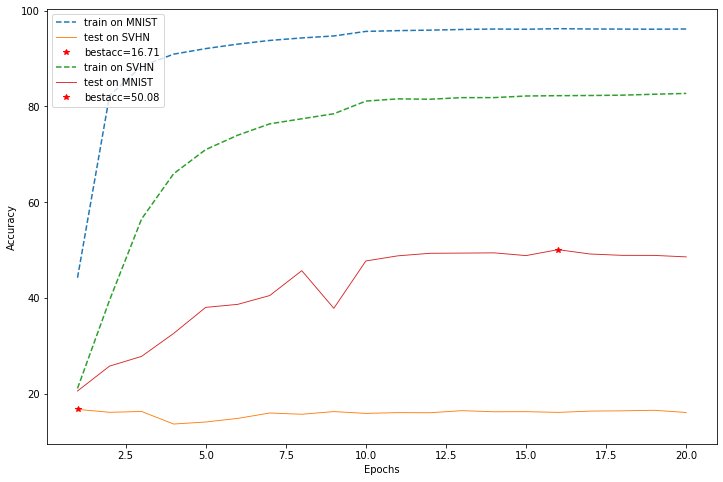

In [14]:
mnist=np.load('q3_part3_mnist_plts.npy')
svhn=np.load('q3_part3_svhn_plts.npy')
plt.figure(figsize=(12.,8.))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
epochs=np.arange(1,mnist.shape[1]+1,1)
plt.plot(epochs,mnist[2],label='train on MNIST',linestyle='--')
plt.plot(epochs,mnist[3],label='test on SVHN',linewidth=0.9)
ep=np.argmax(mnist[3,:])
plt.plot(ep+1,mnist[3,ep],'r*',label='bestacc=%.2f'%mnist[3,ep])
plt.plot(epochs,svhn[2],label='train on SVHN',linestyle='--')
plt.plot(epochs,svhn[3],label='test on MNIST',linewidth=0.9)
ep=np.argmax(svhn[3,:])
plt.plot(ep+1,svhn[3,ep],'r*',label='bestacc=%.2f'%svhn[3,ep])
plt.legend()
plt.savefig('q3_part3_plts.png')
plt.show()

### Q3(4)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
x=np.load('./MNIST/train_x.npy')
y=np.load('./MNIST/train_y.npy')
print(np.bincount(y))
q3_part4_train_x=x[y==0]
q3_part4_train_y=y[y==0]
for j in range(1,5,1):
    q3_part4_train_x=np.concatenate((q3_part4_train_x,x[y==j]))
    q3_part4_train_y=np.concatenate((q3_part4_train_y,y[y==j]))
np.save('q3_part4_train_x.npy',q3_part4_train_x)
np.save('q3_part4_train_y.npy',q3_part4_train_y)

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.fc1   = nn.Linear(16*7*7, 120)
        self.fc2   = nn.Linear(120, 10)
    def forward(self, x):
        out = F.relu(self.conv1(x)) #6,28,28
        out = F.max_pool2d(out, 2) #6,14,14
        out = F.relu(self.conv2(out)) #16,14,14
        out = F.max_pool2d(out, 2) #16,7,7
        out = out.view(out.size(0), -1) 
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

class Mnist(Dataset):
    def __init__(self,train=True):
        self.train = train
        type_ = 'train' if train else 'test'
        Images_path='drive/My Drive/q3/q3_part4_'+type_+'_x.npy'
        Labels_path='drive/My Drive/q3/q3_part4_'+type_+'_y.npy'
        self.imgs=np.load(Images_path)
        self.lbls=np.load(Labels_path)
        print("Data Successfully Loaded into CPU")
    def __getitem__(self, index):
        img, target = self.imgs[index], self.lbls[index]
        img = Image.fromarray(img.astype(np.uint8))
        if self.train == True: # Apply train transform
            t1 = transforms.Compose(
                    [transforms.RandomCrop(28, padding=4), 
                    transforms.RandomHorizontalFlip()]) #can do since dataset has 0,1,2 digits only!
            img = t1(img)
        t2 = transforms.Compose(
            [transforms.ToTensor()])
        img = t2(img)        
        return img, target
    def __len__(self):
        return self.imgs.shape[0]

In [5]:
def classification_performance_metrics(y_pred, y_true, exp_name):
    y_pred = y_pred.astype('uint8')
    y_true = y_true.astype('uint8')
    confusion_matrix = np.zeros((10,10)) #left side - actual, top side - predicted
    for true_label in range(10):
        true_indices = y_true==true_label
        for pred_label in range(10):
            check_pred_labels = y_pred[true_indices]
            confusion_matrix[true_label][pred_label]= (check_pred_labels == pred_label).sum()
    confusion_matrix/=(confusion_matrix.sum(axis=1,keepdims=True))    #normalise it - dividing by column sum
    n=y_true.shape
    tp_indices = y_pred==y_true
    tp = y_true[tp_indices]
    true_y_per_class = np.bincount(y_true)
    labels = true_y_per_class.shape[0]
    tp_per_class = np.zeros((labels,))
    tp_per_class[:np.bincount(tp).shape[0]] = np.bincount(tp)
    predicted_y_per_class = np.zeros((labels,))
    predicted_y_per_class[:np.bincount(y_pred).shape[0]] = np.bincount(y_pred)
    precisions, recalls, F1s = [], [], []
    #precision, recall, F1 for each class
    for i in range(tp_per_class.shape[0]):
        TP = tp_per_class[i]
        TN = tp_per_class.sum() - TP
        FP = predicted_y_per_class[i] - TP
        FN = true_y_per_class[i] - TP
        precision = 100*TP/(TP+FP) if TP+FP!=0 else 0
        recall = 100*TP/(TP+FN) if TP+FN!=0 else 0
        F1 = 2*TP/(2*TP+FP+FN) if TP+FP+FN!=0 else 0
        FPR = FP/(FP+TN) if FP+TN!=0 else 0
        precisions.append(precision)
        recalls.append(recall)
        F1s.append(F1)
    if exp_name!=None:
        #save csv files
        categories=["0","1","2","3","4","5","6","7","8","9"]
        dikt = {}
        dikt['Precision']=np.round(precisions,2)
        dikt['Recall']=np.round(recalls,2)
        dikt['F1']=np.round(F1s,2)
        df = pd.DataFrame(data=dikt,index=categories)
        df.to_csv('%s_perClass.csv'%exp_name)
        df = pd.DataFrame(data=np.round(confusion_matrix,3),index=categories,columns=categories)
        df.to_csv('%s_ConfMat.csv'%exp_name)
    precisions=np.array(precisions)
    recalls=np.array(recalls)
    F1s=np.array(F1s)
    macro_F1=F1s.mean()
    return precisions, recalls, F1s, macro_F1, confusion_matrix
def accuracy(y_pred, y_true):
    return (y_pred==y_true).sum()/y_true.shape[0]
def Save_Stats(trainloss, trainacc, testloss, testacc, exp_name):
    data=[]
    data.append(trainloss)
    data.append(testloss)
    data.append(trainacc)
    data.append(testacc)
    data=np.array(data)
    data.reshape((4,-1))
    np.save('drive/My Drive/q3/%s_plts.npy'%exp_name,data)
    return np.max(data[3,:])

In [8]:
def main():
    exp_name='q3_part4'
    torch.manual_seed(1)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(torch.cuda.get_device_properties(0))
    # Data
    print('==> Preparing data..')
    trainset = Mnist(train=True)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
    testset = Mnist(train=False)
    testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)
    print('==> Building model..')
    net = LeNet()
    net = net.to(device)
    if device == 'cuda':
        cudnn.benchmark = True
    start_epoch = 1
    best_acc=0
    lr=0.1
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=5e-4)
    trainloss, testloss, trainacc, testacc = [], [], [], []
    for epoch in range(start_epoch, start_epoch+20):
        l,a=train(epoch, net, trainloader, device, optimizer, criterion)
        trainloss.append(l)
        trainacc.append(a)
        l,a,best_acc=test(epoch, best_acc, net, testloader, device, criterion, exp_name)
        testloss.append(l)
        testacc.append(a)
    Save_Stats(trainloss, trainacc, testloss, testacc, exp_name)
    with torch.no_grad():
        Images_path='drive/My Drive/q3/q3_part4_test_x.npy'
        Labels_path='drive/My Drive/q3/q3_part4_test_y.npy'
        imgs=np.load(Images_path)
        lbls=np.load(Labels_path)
        imgs=np.expand_dims(imgs,axis=1)
        imgs=torch.from_numpy(imgs)/255.
        lbls=torch.from_numpy(lbls)
        imgs=imgs.to(device)
        lbls=lbls.to(device)
        outputs = net(imgs)
        _, predicted = outputs.max(1)
        classification_performance_metrics(predicted.cpu().numpy(),lbls.cpu().numpy(),exp_name)
def train(epoch, net, trainloader, device, optimizer, criterion):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return train_loss/(batch_idx+1), 100.*correct/total 
def test(epoch, best_acc, net, testloader, device, criterion,exp_name):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
    return test_loss/(batch_idx+1), acc, best_acc

In [10]:
main()

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)
==> Preparing data..
Data Successfully Loaded into CPU
Data Successfully Loaded into CPU
==> Building model..


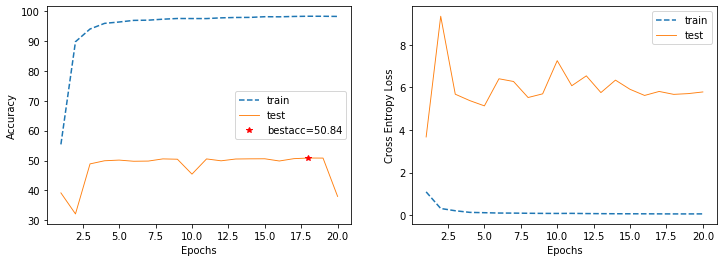

In [16]:
mnist=np.load('q3_part4_plts.npy')
plt.figure(figsize=(12.,4.))
epochs=np.arange(1,mnist.shape[1]+1,1)
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs,mnist[2],label='train',linestyle='--')
plt.plot(epochs,mnist[3],label='test',linewidth=0.9)
ep=np.argmax(mnist[3,:])
plt.plot(ep+1,mnist[3,ep],'r*',label='bestacc=%.2f'%mnist[3,ep])
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.plot(epochs,mnist[0],label='train',linestyle='--')
plt.plot(epochs,mnist[1],label='test',linewidth=0.9)
plt.legend()
plt.savefig('q3_part4_plts.png')
plt.show()